# The Sumcheck Protocol

In [335]:
from typing import List, Tuple, Union
from functools import reduce
from random import randint
from math import log2


class FFE:
    
    element: int
    
    modulus: int
    
    def __init__(self, element: int, modulus: int):
        self.element = element % modulus
        self.modulus = modulus
        
    def __add__(self, rhs: 'FFE'):
        if self.modulus != rhs.modulus:
            raise Exception("Modulus Mismatch")
        element = (self.element + rhs.element) % self.modulus
        return FFE(element, self.modulus)
        
    def __sub__(self, rhs: 'FFE'):
        if self.modulus != rhs.modulus:
            raise Exception("Modulus Mismatch")
        element = (self.element - rhs.element) % self.modulus
        return FFE(element, self.modulus)
    
    def __mul__(self, rhs: 'FFE'):
        if self.modulus != rhs.modulus:
            raise Exception("Modulus Mismatch")
        element = (self.element * rhs.element) % self.modulus
        return FFE(element, self.modulus)
    
    def __eq__(self, rhs: 'FFE'):
        return (self.element == rhs.element) and (self.modulus == rhs.modulus)
    
    def __str__(self):
        return f"FFE(element: {self.element}, modulus: {self.modulus})"
    
    def __repr__(self):
        return f"FFE(element: {self.element}, modulus: {self.modulus})"
    
    
RANDOM_NUM_MAX = 1_000_000_000

class FF:
    
    modulus: int
    
    def __init__(self, modulus: int):
        self.modulus = modulus
        
    def new(self, element: int) -> FFE:
        return FFE(element, self.modulus)
    
    def zero(self) -> FFE:
        return self.new(0)
    
    def one(self) -> FFE:
        return self.new(1)
    
    def random_value(self) -> FFE:
        return FFE(randint(0, RANDOM_NUM_MAX), self.modulus)
        

class Linear_Polynomial:
    
    evaluations: List[FFE]
    
    num_of_vars = 1
    
    ff: FF
    
    def __init__(self, ff: FF, evaluations: List[FFE]):
        if len(evaluations) != 2:
            raise Exception("Invalid evaluations")
        self.evaluations = evaluations
        self.ff = ff
        
    def evaluate(self, x: FFE) -> FFE:
        evaluations = self.evaluations.copy()
        eval_1 = evaluations[0]
        eval_2 = evaluations[1]
        return (eval_1 - (eval_1 * x)) + (eval_2 * x)
    
    def __str__(self):
        return f"Linear Polynomial({self.evaluations})"
    
    def __repr__(self):
        return f"Linear Polynomial({self.evaluations})"
    
    def __add__(self, rhs: 'Linear_Polynomial'):
        if (self.num_of_vars != rhs.num_of_vars):
            raise Exception("Invalid Operation")
        new_evals = [(x + y) for (x, y) in zip(self.evaluations, rhs.evaluations)]
        new_poly = Linear_Polynomial(self.ff, new_evals)
        return new_poly

    
class Multilinear_Polynomial:
    
    evaluations: List[FFE]
    
    num_of_vars: int
        
    ff: FF
    
    def __init__(self, ff: FF, evaluations: List[FFE], num_of_vars: int):
        self.ff = ff
        if num_of_vars < 2:
            raise Exception("Invalid number of variables")
        num_of_evaluation_points = 2 ** num_of_vars
        length_of_evaluation_points = len(evaluations)
        if length_of_evaluation_points == num_of_evaluation_points:
            self.num_of_vars = num_of_vars
            self.evaluations = evaluations
        elif length_of_evaluation_points < num_of_evaluation_points:
            padding = [ff.zero() for _ in range(num_of_evaluation_points - length_of_evaluation_points)]
            evaluations = evaluations + padding
            self.evaluations = evaluations
            self.num_of_vars = num_of_vars
        else:
            self.evaluations = evaluations[:num_of_evaluation_points]
            self.num_of_vars = num_of_vars
            
    def __str__(self):
        return f"Multilinear_Polynomial({self.evaluations})"
    
    def __repr__(self):
        return f"Multilinear_Polynomial({self.evaluations})"
    
    def __add__(self, rhs: 'Multilinear_Polynomial'):
        if (self.ff.modulus != rhs.ff.modulus) or (self.num_of_vars != rhs.num_of_vars):
            raise Exception("Invalid Operation")
        new_evals = [(x + y) for (x, y) in zip(self.evaluations, rhs.evaluations)]
        new_poly = Multilinear_Polynomial(self.ff, new_evals, self.num_of_vars)
        return new_poly
    
    def __mul__(self, rhs: 'Multilinear_Polynomial'):
        if (self.ff.modulus != rhs.ff.modulus) or (self.num_of_vars != rhs.num_of_vars):
            raise Exception("Invalid Operation")
        new_evals = []
        for x in self.evaluations:
            for y in rhs.evaluations:
                new_evals.append(x * y)
        new_poly = Multilinear_Polynomial(self.ff, new_evals, self.num_of_vars ** 2)
        return new_poly
    
    @staticmethod
    def get_pairing_index(var_index: int, num_of_vars: int):
        if var_index < 0 or var_index > num_of_vars - 1:
            raise Exception("Invalid variable index")
        num_of_evals = 2 ** num_of_vars
        offset = num_of_evals // (2 ** (var_index + 1))
        indices = list(range(num_of_evals))
        pairs = []
        for i in range(num_of_evals // 2):
            start = indices[0]
            stop = start + offset
            pair = (start, stop)
            indices.remove(start)
            indices.remove(stop)
            pairs.append(pair)
        return pairs
    
    @staticmethod
    def decrease_indexes_and_vars(indexes: List[int], variables: List[int]) -> Tuple[List[int], List[int]]:
        return (list(map(lambda x: x - 1, indexes[1:])),  variables[1:])

    def single_partial_evaluate(self, var_index: int, var: FFE) -> Union[Linear_Polynomial, 'Multilinear_Polynomial']:
        pairs = self.get_pairing_index(var_index, self.num_of_vars)
        
        new_points = []
        
        for pair in pairs:
            y_1 = self.evaluations[pair[0]]
            x_2 = self.ff.one()
            y_2 = self.evaluations[pair[1]]
            slope = y_2 - y_1
            c = y_2 - (slope * x_2)
            value = (slope * var) + c
            new_points.append(value)
        
        if len(new_points) == 2:
            return Linear_Polynomial(self.ff, new_points)
        else:
            num_of_vars = log2(len(new_points))
            return Multilinear_Polynomial(self.ff, new_points, int(num_of_vars))
        
    def partial_evaluate(self, indexes: List[int], variables: Tuple[FFE]):
        if len(indexes) != len(variables):
            raise Exception("length of indexes should be equal to length of variables")
        if len(variables) > self.num_of_vars - 1:
            raise Exception("invalid number of variables")
                    
        new_poly = self.single_partial_evaluate(indexes[0], variables[0])
        new_indexes, new_variables = self.decrease_indexes_and_vars(indexes, variables)
        
        if len(new_indexes) == 0:
            return new_poly
        else:
            return new_poly.partial_evaluate(new_indexes, new_variables)
    
    def evaluate(self, variables: Tuple[FFE]):
        if len(variables) != self.num_of_vars:
            raise Exception("Wrong number of variables")
        linear_poly = self.partial_evaluate([i for i in range(self.num_of_vars - 1)], variables[:self.num_of_vars - 1])
        return linear_poly.evaluate(variables[-1])



class SumCheck_Protocol:
    
    @staticmethod
    def sum(poly: Multilinear_Polynomial):
        return reduce(lambda x, y: x + y, poly.evaluations)

## Walkthrough of the Sumcheck Protocol

#### Setup

GOAL: A prover wants to prove to the verifier the sum of a polynomial over the boolean hypercube

Polynomial: $f(x, y, z) = x + y + z + 7$

In [339]:
ff = FF(17)
evaluations = [ff.new(7), ff.new(8), ff.new(8), ff.new(9), ff.new(8), ff.new(9), ff.new(9), ff.new(10)]
mult_1 = Multilinear_Polynomial(ff, evaluations, 3)

#### STEP 1:
The prover computes the sum of the polynomial over the boolean hypercube and sends to the verifier

In [342]:
sum_check = SumCheck_Protocol()
h = sum_check.sum(mult_1)

#### STEP 2: 

The prover computes a polynomial $g_1(x)$ and sends to the verifier $$g_1(x) = f(x, 0, 0) + f(x, 0, 1) + f(x, 1, 0) + f(x, 1, 1)$$

In [345]:
poly_1 = mult_1.partial_evaluate([1, 2], (ff.zero(), ff.zero())) ## f(x, 0, 0)
poly_2 = mult_1.partial_evaluate([1, 2], (ff.zero(), ff.one())) ## f(x, 0, 1)
poly_3 = mult_1.partial_evaluate([1, 2], (ff.one(), ff.zero())) ## f(x, 1, 0)
poly_4 = mult_1.partial_evaluate([1, 2], (ff.one(), ff.one())) ## f(x, 1, 1)
poly_5 = poly_1 + poly_2 + poly_3 + poly_4 ## f(x) = f(x, 0, 0) + f(x, 0, 1) + f(x, 1, 0) + f(x, 1, 1)
g_1_of_x = poly_5

#### STEP 3:

The verifier stores $g_1(x)$ as $s_1(x)$

In [348]:
s_1_of_x = g_1_of_x

#### STEP 4:

The verifier checks that $h == s_1(0) + s_1(1)$

In [351]:
x = s_1_of_x.evaluate(ff.zero())
y = s_1_of_x.evaluate(ff.one())
assert h == x + y, "Invalid proof"

#### STEP 5:

The verifier generates a random value $r_1$ and sends to the prover

In [354]:
r1 = ff.random_value()

#### STEP 6:

The prover computes $g_2(y) = f(r_1, y, 0) + f(r_1, y, 1)$ and sends to the verifier

In [357]:
poly_1 = mult_1.partial_evaluate([0, 2], (r1, ff.zero())) ## f(r1, y, 0)
poly_2 = mult_1.partial_evaluate([0, 2], (r1, ff.one())) ## f(r1, y, 1)
poly_3 = poly_1 + poly_2 ## f(y) = f(r1, y, 0) + f(r1, y, 1)
g_2_of_y = poly_3

#### STEP 7:

The verifier stores $g_2(y)$ as $s_2(y)$

In [360]:
s_2_of_y = g_2_of_y

#### STEP 8:

The verifier checks that $s_1(r_1) == s_2(0) + s_2(1)$

In [363]:
x = s_1_of_x.evaluate(r1)
y = s_2_of_y.evaluate(ff.zero())
z = s_2_of_y.evaluate(ff.one())
assert x == y + z, "Invalid proof"

#### STEP 9:

The verifier generates a random value $r_2$ and sends to the prover

In [366]:
r2 = ff.random_value()

#### STEP 10:

The prover computes $g_3(z) = f(r_1, r_2, z)$ and sends to the verifier

In [369]:
poly_1 = mult_1.partial_evaluate([0, 1], (r1, r2)) ## f(r1, r2, z)
g_3_of_z = poly_1

#### STEP 11:

The verifier stores $g_3(z)$ as $s_3(z)$

In [372]:
s_3_of_z = g_3_of_z

#### STEP 12:

The verifier checks that $s_2(r2) == s_3(0) + s_3(1)$

In [375]:
x = s_2_of_y.evaluate(r2)
y = s_3_of_z.evaluate(ff.zero())
z = s_3_of_z.evaluate(ff.one())
assert x == y + z, "Invalid proof"

#### STEP 13:

The verifier generates a random value $r_3$ and sends to the prover

In [378]:
r3 = ff.random_value()

#### STEP 14:

The prover computes $f(r_1, r_2, r_3)$ and sends to the verifier

In [381]:
evaluation = mult_1.evaluate((r1, r2, r3))

#### LAST STEP:

The verifier checks that $s_3(r_3) == f(r_1, r_2, r_3)$

In [384]:
x = s_3_of_z.evaluate(r3)
assert x == evaluation, "Invalid proof"

## Applications of the the Sumcheck Protocol

### Interactive Proof(IP) for Matrix Multiplication(`MatMult`) Using the Sumcheck Protocol

The best known algorithm for `MatMult` runs in $O(n^{2.37286})$ but it's not pratical. 

Check it out [here](https://arxiv.org/abs/2010.05846).

We also showed how to check that product matrix `A.B == C` using the Freivalds Algorithm shown above.

Here, we would show how to make the checking an IP using the Sumcheck Protocol.

That is, the prover wants to prove to the verifier that he knows a matrix C such that product matrix of `A` and `B` equals `C`.



In [388]:
from math import log2
from functools import reduce

def generate_n_by_n_matrix(n):
    
    res = []
    
    for _ in range(n):
        row = [ff.random_value() for _ in range(n)]
        res.append(row)
        
    return res


def matrix_product(ff: FF, A: List[List[FFE]], B: List[List[FFE]]):
    n = len(A)
    # Initialize an n x n matrix with zeros for the result
    C = [[ff.zero()] * n for _ in range(n)]
    
    # Perform matrix multiplication
    for i in range(n):
        for j in range(n):
            for k in range(n):
                C[i][j] += A[i][k] * B[k][j]
    
    return C

def matrix_to_one_dim_list(x: List[List[FFE]]):
    
    res = []
    
    for row in x:
        res += row
        
    return res


class MulOfLinearPoly:
    
    a: Linear_Polynomial
    
    b: Linear_Polynomial
    
    def __init__(self, a: Linear_Polynomial, b: Linear_Polynomial):
        if a.num_of_vars != b.num_of_vars:
            raise Exception("Invalid inputs")
            
        if len(a.evaluations) != 2:
            raise Exception("Invalid inputs")
            
        if a.ff.modulus != b.ff.modulus:
            raise Exception("Invalid inputs")
            
        self.a = a
        self.b = b
        
    def __str__(self):
        return f"({self.a}, {self.b})"
    
    def __repr__(self):
        return f"({self.a}, {self.b})"
    
    def evaluate(self, x: FFE) -> FFE:
        val_1 = self.a.evaluate(x)
        val_2 = self.b.evaluate(x)
        return val_1 * val_2


class MulOfMultilinearPoly:
    
    """
    This represents of the multiplication of two multilinear polynomials.
    
    The can be partially evaluated at opposite ends(that is, A(X_1, b)B(b, X_2)) and 
    summed over the boolean hypercube
    """
    
    a: Multilinear_Polynomial
    
    b: Multilinear_Polynomial
    
    num_of_vars: int
    
    ff: FF
        
    def __init__(self, a: Multilinear_Polynomial, b: Multilinear_Polynomial):
        if a.num_of_vars != b.num_of_vars:
            raise Exception("Invalid inputs")
            
        if a.ff.modulus != b.ff.modulus:
            raise Exception("Invalid inputs")
        
        self.ff = a.ff
        self.a = a
        self.b = b
        self.num_of_vars = a.num_of_vars
        
    def __str__(self):
        return f"({self.a}, {self.b})"
    
    def __repr__(self):
        return f"({self.a}, {self.b})"
    
    def partial_evaluate_opposite(self, x1: List[FFE], x2: List[FFE]):            
        if len(x1) != len(x2):
            raise Exception("Invalid inputs")
            
        if len(x1) != (self.num_of_vars // 2):
            raise Exception("Invalid input length")
        
        a = self.a.partial_evaluate([i for i in range(self.num_of_vars // 2)], x1)
        b = self.b.partial_evaluate([i + (self.num_of_vars // 2) for i in range(self.num_of_vars // 2)], x2)
        return MulOfMultilinearPoly(a, b)
    
    def partial_evaluate(self, indexes: List[int], variables: Tuple[FFE]):
        a = self.a.partial_evaluate(indexes, variables)
        b = self.b.partial_evaluate(indexes, variables)
        if len(a.evaluations) == 2 and len(b.evaluations) == 2:
            return MulOfLinearPoly(a, b)
        return MulOfMultilinearPoly(a, b)
    
    def evaluate(self, variables: Tuple[FFE]):
        eval_1 = self.a.evaluate(variables)
        eval_2 = self.b.evaluate(variables)
        return eval_1 * eval_2
     
    def sum(self):
        res = self.ff.zero()
        for (x, y) in zip(self.a.evaluations, self.b.evaluations):
            res = res + (x * y)
        return res
    
    
class AddOfMulOfLinearPoly:
    
    polynomials: List[MulOfLinearPoly]
    
    def __init__(self, polynomials: List[MulOfLinearPoly]):
        self.polynomials = polynomials
        
    def evaluate(self, x: FFE) -> FFE:
        evaluations = [linear_poly.evaluate(x) for linear_poly in self.polynomials]
        return reduce(lambda x, y: x + y, evaluations)

#### Walkthrough of the Sumcheck Protocol for MatMult

Protocol overview:

- There are three $n$ by $n$ matrices $A$, $B$ and $C$ such that the product $A.B$ equals $C$ and the prover wants to prove this to the verifier
- Firstly, we have to convert each of the matrix to a multilinear polynomial such that:$$\{0, 1\}^{\log_2 n} \times \{0, 1\}^{\log_2 n}  \to \mathbb{F}$$That way, we have a multilinear polynomial with $\log_2 n + \log_2 n$ variables where the left half of the variable represent the row and the right half represent the column of the matrix in binary and the evaluation at that variable is the value at the index in the matrix. For example: When $n = 4$, then $\log_2 n = 2$ $$M = 
\begin{bmatrix}
0 & 1 & 2 & 3 \\[0.3em]
4 & 5 & 6 & 7 \\[0.3em]
8 & 9 & 10 & 11 \\[0.3em]
12 & 13 & 14 & 15 
\end{bmatrix}$$The multilinear polynomial for this matrix is as follows:
$$\tilde M(0, 0, 0, 0) = 0\\ \tilde M(0, 0, 0, 1) = 1\\ \tilde M(0, 0, 1, 0) = 2\\ \tilde M(0, 0, 1, 1) = 3\\ \tilde M(0, 1, 0, 0) = 4\\ \tilde M(0, 1, 0, 1) = 5\\ \tilde M(0, 1, 1, 0) = 6\\ \tilde M(0, 1, 1, 1) = 7\\ \tilde M(1, 0, 0, 1) = 8\\ \tilde M(1, 0, 0, 1) = 9\\ \tilde M(1, 0, 1, 0) = 10\\ \tilde M(1, 0, 1, 1) = 11\\ \tilde M(1, 1, 0, 0) = 12\\ \tilde M(1, 1, 0, 1) = 13\\ \tilde M(1, 1, 1, 0) = 14\\ \tilde M(1, 1, 1, 1) = 15$$

- Now, we have converted from a checking matrices to checking of polynomials:$$\tilde C(x, y) = \sum_{b \in \{0, 1\}^{\log_2n}} \tilde A(x, b).\tilde B(b, y)$$ where $x, y \in \{0, 1\}^{\log_2 n}$. (*check out how product of $n$ by $n$ matrices works to understand the expression better*)

- Lastly, before the sumcheck the verifier generates values $r_1, r_2 \in \mathbb{F}^{log_2 n}$ to compute $\tilde C(r_1, r_2) = \sum_{b \in \{0, 1\}^{\log_2n}} \tilde A(r_1, b).\tilde B(b, r_2)$. This is an IP for evaluating $\tilde C(r_1, r_2)$. This also gives us a new polynomial $g(z) = \tilde A(r_1, z).\tilde B(z, r_2)$ that we would be performing the sumcheck protocol on.

##### STEP 1:

Define the matrix, convert to a multilinear extension

In [392]:
n = 16

log_n = int(log2(n))

ff = FF(17)

A = generate_n_by_n_matrix(n)

B = generate_n_by_n_matrix(n)

num_of_vars = log_n + log_n

evaluations_a = matrix_to_one_dim_list(A)
multi_poly_A = Multilinear_Polynomial(ff, evaluations_a, num_of_vars)

evaluations_b = matrix_to_one_dim_list(B)
multi_poly_B = Multilinear_Polynomial(ff, evaluations_b, num_of_vars)

##### STEP 2:

Compute $\tilde C(r_1, r_2) = \sum_{b \in \{0, 1\}^{\log_2n}} \tilde A(r_1, b).\tilde B(b, r_2)$ as an IP for evaluation and also the initial sum that would be sent to the verifier.
###### Steps:
- Compute $\tilde A(r_1, b)$ be partially evaluating at $r_1$
- Compute $\tilde B(b, r_2)$ be partially evaluating at $r_2$
- Compute $g(b) = \tilde A(r_1, b) .\tilde B(b, r_2)$
- Compute the sum of $g(b)$ over the boolean hypercube

In [395]:
r1 = [ff.random_value() for _ in range(log_n)]

r2 = [ff.random_value() for _ in range(log_n)]

mom_poly_1 = MulOfMultilinearPoly(multi_poly_A, multi_poly_B)

mom_poly_2 = mom_poly_1.partial_evaluate_opposite(r1, r2)

h = mom_poly_2.sum()

##### STEP 3:

The prover computes a polynomial $g_1(x)$ and sends to the verifier. Recall that $b \in F^{log_2 n}$. $$g_1(x) = g(x, 0, 0, 0) + g(x, 0, 0, 1) + g(x, 0, 1, 0) + g(x, 0, 1, 1) + g(x, 1, 0, 0) + g(x, 1, 0, 1) + g(x, 1, 1, 0) + g(x, 1, 1, 1)$$



In [398]:
poly_1 = mom_poly_2.partial_evaluate([1, 2, 3], (ff.zero(), ff.zero(), ff.zero())) # g(x, 0, 0, 0)
poly_2 = mom_poly_2.partial_evaluate([1, 2, 3], (ff.zero(), ff.zero(), ff.one())) # g(x, 0, 0, 1)
poly_3 = mom_poly_2.partial_evaluate([1, 2, 3], (ff.zero(), ff.one(), ff.zero())) # g(x, 0, 1, 0)
poly_4 = mom_poly_2.partial_evaluate([1, 2, 3], (ff.zero(), ff.one(), ff.one())) # g(x, 0, 1, 1)
poly_5 = mom_poly_2.partial_evaluate([1, 2, 3], (ff.one(), ff.zero(), ff.zero())) # g(x, 1, 0, 0)
poly_6 = mom_poly_2.partial_evaluate([1, 2, 3], (ff.one(), ff.zero(), ff.one())) # g(x, 1, 0, 1)
poly_7 = mom_poly_2.partial_evaluate([1, 2, 3], (ff.one(), ff.one(), ff.zero())) # g(x, 1, 1, 0)
poly_8 = mom_poly_2.partial_evaluate([1, 2, 3], (ff.one(), ff.one(), ff.one())) # g(x, 1, 1, 1)

g_1_of_x = AddOfMulOfLinearPoly([poly_1, poly_2, poly_3, poly_4, poly_5, poly_6, poly_7, poly_8])

##### STEP 4:

The verifier stores $g_1(x)$ as $s_1(x)$

In [401]:
s_1_of_x = g_1_of_x

##### STEP 5:

The verifier checks that $h == s_1(0) + s_1(1)$

In [404]:
x = s_1_of_x.evaluate(ff.zero())
y = s_1_of_x.evaluate(ff.one())
assert h == x + y, "Invalid proof"

##### STEP 6:

The verifier generates a random value $r_1$ and sends to the prover

In [407]:
r1 = ff.random_value()

##### STEP 7:

The prover computes $g_2(y) = g(r_1, y, 0, 0) + g(r_1, y, 0, 1) + g(r_1, y, 1, 0) + g(r_1, y, 1, 1)$ and sends to the verifier

In [410]:
poly_1 = mom_poly_2.partial_evaluate([0, 2, 3], (r1, ff.zero(), ff.zero())) # g(r1, y, 0, 0)
poly_2 = mom_poly_2.partial_evaluate([0, 2, 3], (r1, ff.zero(), ff.one())) # g(r1, y, 0, 1)
poly_3 = mom_poly_2.partial_evaluate([0, 2, 3], (r1, ff.one(), ff.zero())) # g(r1, y, 1, 0)
poly_4 = mom_poly_2.partial_evaluate([0, 2, 3], (r1, ff.one(), ff.one())) # g(r1, y, 1, 1)

g_2_of_y = AddOfMulOfLinearPoly([poly_1, poly_2, poly_3, poly_4])

##### STEP 8:

The verifier stores $g_2(y)$ as $s_2(y)$

In [413]:
s_2_of_y = g_2_of_y

##### STEP 9:

The verifier checks that $s_1(r_1) == s_2(0) + s_2(1)$

In [416]:
x = s_1_of_x.evaluate(r1)
y = s_2_of_y.evaluate(ff.zero())
z = s_2_of_y.evaluate(ff.one())
assert x == y + z, "Invalid proof"

##### STEP 10:

The verifier generates a random value $r_2$ and sends to the prover

In [419]:
r2 = ff.random_value()

##### STEP 11:

The prover computes $g_3(w) = g(r_1, r_2, w, 0) + g(r_1, r_2, w, 1)$ and sends to the verifier

In [422]:
poly_1 = mom_poly_2.partial_evaluate([0, 1, 3], (r1, r2, ff.zero())) # g(r1, r2, w, 0)
poly_2 = mom_poly_2.partial_evaluate([0, 1, 3], (r1, r2, ff.one())) # g(r1, r2, w, 1)

g_3_of_w = AddOfMulOfLinearPoly([poly_1, poly_2])

##### STEP 12:

The verifier stores $g_3(w)$ as $s_3(w)$

In [425]:
s_3_of_w = g_3_of_w

##### STEP 13:

The verifier checks that $s_2(r_2) == s_3(0) + s_3(1)$

In [428]:
x = s_2_of_y.evaluate(r2)
y = s_3_of_w.evaluate(ff.zero())
z = s_3_of_w.evaluate(ff.one())
assert x == y + z, "Invalid proof"

##### STEP 14:

The verifier generates a random value $r_3$ and sends to the prover

In [431]:
r3 = ff.random_value()

##### STEP 15:

The prover computes $g_4(z) = g(r_1, r_2, r_3, z)$ and sends to the verifier

In [434]:
poly_1 = mom_poly_2.partial_evaluate([0, 1, 2], (r1, r2, r3)) # g(r1, r2, r3, z)

g_4_of_z = poly_1

##### STEP 16:

The verifier stores $g_4(z)$ as $s_4(z)$

In [437]:
s_4_of_z = g_4_of_z

##### STEP 17:

The verifier checks that $s_3(r_3) == s_4(0) + s_4(1)$

In [440]:
x = s_3_of_w.evaluate(r3)
y = s_4_of_z.evaluate(ff.zero())
z = s_4_of_z.evaluate(ff.one())
assert x == y + z, "Invalid proof"

##### STEP 18:

The verifier generates a random value $r_4$ and sends to the prover

In [443]:
r4 = ff.random_value()

##### STEP 19

The prover computes $g(r_1, r_2, r_3, r_4)$ and sends to the verifier

In [446]:
evaluation = mom_poly_2.evaluate((r1, r2, r3, r4))

##### LAST STEP:

The verifier checks that $s_4(r_4) == g(r_1, r_2, r_3, r_4)$

In [449]:
x = s_4_of_z.evaluate(r4)
assert x == evaluation, "Invalid proof"

### Counting Triangles Protocol

The counting triangle problem is simply a problem of checking 3-cycled vertices we have in a graph.

For example, 

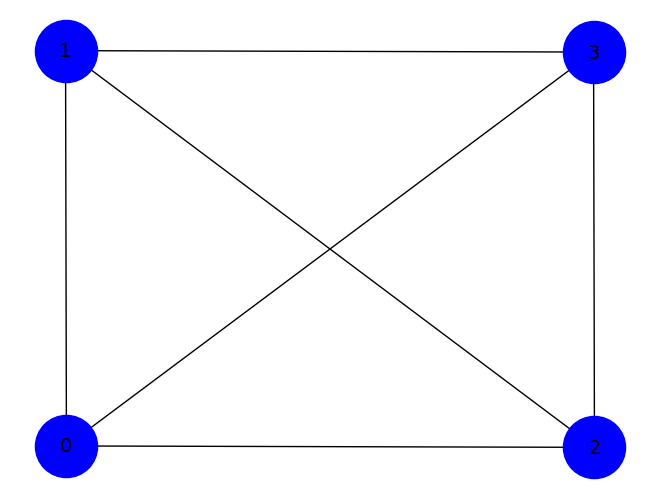

In [453]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

adj_matrix = np.array([[0, 1, 1, 1],
                       [1, 0, 1, 1],
                       [1, 1, 0, 1],
                       [1, 1, 1, 0],
                      ])

G_from_matrix = nx.from_numpy_array(adj_matrix)

nx.draw(G_from_matrix, with_labels=True, node_color='blue', edge_color='black', node_size=2000, font_size=14)

plt.show()